# Homework - Categorization and Model Comparison Part B (40/110 points)


by _Todd Gureckis_ and _Brenden Lake_  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/


<div class="alert alert-danger" role="alert">
  This homework is due before midnight on April 22 2024. 
</div>


---


In [1]:
from IPython.display import display
import string as str
import os
import numpy as np
import seaborn as sns
import pandas as pd
import math
from random import random, randint, shuffle, uniform
from scipy.optimize import fmin, brute
from scipy.special import comb  # gets the combinations function
from exemplarproto import *  # this grabs much of the code from Part A of the homework

## Fitting the models using maximum likelihood


As mentioned in the lecture, RMSE is not always an ideal mechanism for fitting
models. One reason is that it is insensitive to the number of observations
that define each data point. For example, remember in our experiment that
participants saw the prototype item four times at test. In contrast, there
were 20 different "new" patterns. This means there are five times as many
trials contributing to the "new" bar in this graph as for the prototype
patterns. Since RMSE measures the raw deviation of the average model
predictions from those of the model it doesn't take into account these issues.
Thus, we would like to also evaluate these two models using maximum
likelihood.

The key to this is going to be the provided function below which computes the
likelihood of a particular set of data under a binomial probability model.:


In [2]:
################################
# computeLogLikelihood
# N = number of observations
# S = number of "successes" (i.e., endorsements)
# p = predicted probability of successes by the model
################################
def computeLogLikelihood(N, S, p):
    p = p if p > 0.0 else 0.0 + 1e-10
    p = p if p < 1.0 else 1.0 - 1e-10
    try:
        result = math.log(comb(N, S)) + (S * math.log(p) + (N - S) * math.log(1.0 - p))
    except:
        print(N, S, p)  # this shouldn't happen but just in case
        result = 0
    return result


def pandas_ll(row):
    return computeLogLikelihood(
        row["Total"], row["N_Yes"], row["Probability of Endorsement"]
    )

A short explanation may be in order: the models predictions take the form of
probabilities of endorsement for each of the prototype, low, high, random, and
old items. If you find out that people endorse the prototype on 2 out of 2
trials how likely is this outcome given that the model (for a particular set
of parameters ) predicts an endorsement of p=0.8? Three numbers are required
to do this for each data point N, the number of trials/presentations within
the stimulus class, S the number of successes observed (S<=N), and p the
predicted probability. Then you can turn the crank on the above
`computeLogLikelihood()` function which returns the probability that you would
get $S$ successes in $N$ trials if the true probability was $p$ (make sure you
understand what is happening in `computeLogLikelihood`). You can sum these log
likelihoods for each stimulus class (prototype, low, high, random, old) to
compute a total log(likelihood) of the data for any given model with any set
of parameters. For this homework will we focus on fitting the group data
rather than to individuals.


To get the data formatted into an appropriate shape for fitting likelihoods we
provide a function `get_human_results_ll()` which returns a Pandas data frame
containing the number of times a pattern of a particular type was endorsed and
the number of times it was presented for each subject.


In [3]:
human_res = get_human_results_ll()
human_res

,Subject,Condition,Stimulus Type,N_Yes,Total
0,./data/8.dat,cat,Prototype,4,4
1,./data/8.dat,cat,Low,4,4
2,./data/8.dat,cat,High,10,10
3,./data/8.dat,cat,Random,15,20
4,./data/8.dat,cat,Old,20,20
...,...,...,...,...,...
0,./data/7.dat,rec,Prototype,3,4
1,./data/7.dat,rec,Low,4,4
2,./data/7.dat,rec,High,8,10
3,./data/7.dat,rec,Random,0,20


This reorganizes the data per condition.


In [4]:
human_data = human_res.groupby(["Condition", "Stimulus Type"]).sum()
human_data

/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/3210597102.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  human_data = human_res.groupby(["Condition", "Stimulus Type"]).sum()


N_Yes  Total
Condition Stimulus Type              
cat       High              49     70
          Low               26     28
          Old              110    140
          Prototype         25     28
          Random            37    140
rec       High              20     70
          Low               16     28
          Old               89    140
          Prototype         18     28
          Random             7    140

Finally these function allow us to compute the negative log likelihood of the
data given the model.


In [5]:
def fit_exemplar_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0 * fitted_data.apply(pandas_ll, axis=1).sum()


def fit_prototype_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0 * fitted_data.apply(pandas_ll, axis=1).sum()

<div class="alert alert-success" role="alert">
<h3> Problem 6 (20 points) </h3><br>
The cell blocks below allow you to fit the exemplare model and the prototype model to the dataset we considered in Part A of the homework. Make sure you understand and follow the code provided above and in the provided library (exemplarproto.py).  Next, try altering the parameters to minimize the negative log likelihood score.  When you think you have found the best fit parameters for both the exemplar and prototype models report your final parameter values along with the plot of the resulting model predictions.  In a markdown cell describe which model you believe fits better.  Is this conclusion the same or different from what you considered in Part 4 of the homework?  If the fit looks different, why?
</div>


The parameters for exampler model is c_cat, k_cat, c_rec, k_rec = 1.49337853, 0.35625086, 1.93442909, 0.78516283

The parameters for prototype model is c_cat, k_cat, c_rec, k_rec = 1.58812619, 0.03164735, 1.87912332, 0.08400976

The exampler model fits better with a smaller negative log likelihood. The conclusion is the same as Part 4.

The fit looks a little different, because the optimization method depends on the maximum likelihood, where the number of observations is considered.


**Exemplar model**


In [6]:
human = human_res.groupby(["Condition", "Stimulus Type"], as_index=False).sum()
exempler_min = fmin(fit_exemplar_model_nll, [1.8, 0.2, 1.9, 0.7], args=(human,),maxiter=150)
print(f"best exemplar model parameters: {exempler_min}, NLL: {fit_exemplar_model_nll(exempler_min, human)}")

/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/3058378651.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  human = human_res.groupby(["Condition", "Stimulus Type"], as_index=False).sum()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_o

Optimization terminated successfully.
         Current function value: 28.268922
         Iterations: 127
         Function evaluations: 211
best exemplar model parameters: [1.48768493 0.35960503 1.9303954  0.78402637], NLL: 28.268922097525063


/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()


/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/1882745255.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  human = human_res.groupby(["Condition", "Stimulus Type"], as_index=False).sum()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()


The negative log score is 28.271454357135767


<Axes: xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

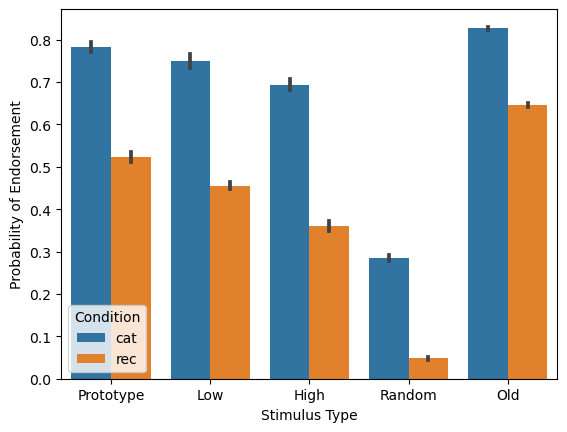

In [8]:
human = human_res.groupby(["Condition", "Stimulus Type"], as_index=False).sum()

params = [1.49337853, 0.35625086, 1.93442909, 0.78516283]
nllfit = fit_exemplar_model_nll(params, human)
print(f"The negative log score is {nllfit}")

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(
    x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=res
)

**Prototype Model**


In [9]:
prototype_min = fmin(fit_prototype_model_nll, [1.62, 0.03, 1.48, 0.16], args=(human,),maxiter=150)
print(f"best prototype model parameters: {prototype_min}, NLL: {fit_prototype_model_nll(prototype_min, human)}")

/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, num

Optimization terminated successfully.
         Current function value: 32.246756
         Iterations: 114
         Function evaluations: 184
best prototype model parameters: [1.58812619 0.03164735 1.87912332 0.08400976], NLL: 32.24675619562059


/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, num

The negative log score is 32.24675619580016


/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/1703721815.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  human = human_res.groupby(["Condition", "Stimulus Type"], as_index=False).sum()
/var/folders/7v/g7hpq3zs6q5d6flvr_1cf1j40000gn/T/ipykernel_9436/836206044.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model = predictions.groupby(["Condition", "Stimulus Type"], as_index=False).mean()


<Axes: xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

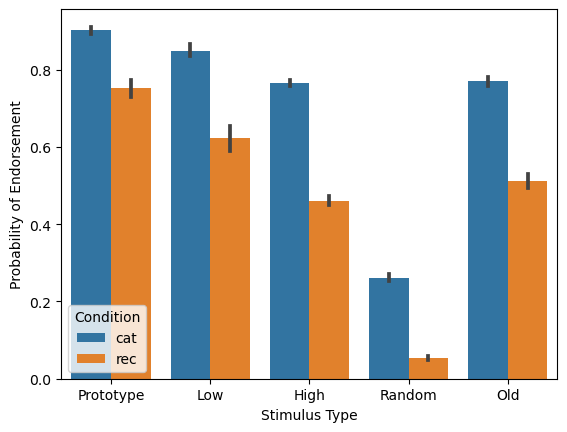

In [10]:
human = human_res.groupby(["Condition", "Stimulus Type"], as_index=False).sum()

params = [1.58812619, 0.03164735, 1.87912332, 0.08400976]
nllfit = fit_prototype_model_nll(params, human)
print(f"The negative log score is {nllfit}")

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(
    x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=res
)

**Human data again for reference**


<Axes: xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

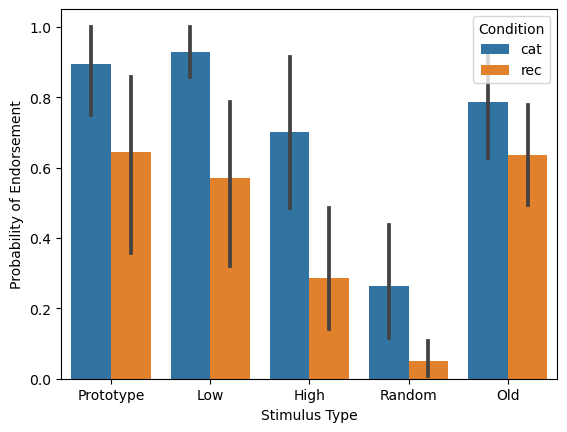

In [11]:
sns.barplot(
    x="Stimulus Type",
    y="Probability of Endorsement",
    hue="Condition",
    data=get_human_results(),
)

<div class="alert alert-success" role="alert">
<h3> Problem 7 (10 points) </h3><br>
A famous saying is the "All models are wrong, but some are useful" (George Box).  Do you think the exemplar or prototype model provides the best account of the data?  Refer to particular patterns in the data that you believe the different models do a better job with.
</div>


Both the exemplar and prototype model can partialy represent the data. 

The exempler model can better represent the pattern that the Old stimulus would have highest endorsement in recognition condition, and prototype stimulus would have high endorsement in both conditions. However, for categorization condition, exmempler model could not fit the relationship accross stimulus well.

The prototype model can better represent the pattern in the categorization condition, where prototype stimulus would have relatively high endorsement. However, it could not fit the case that human better endorse low distortion stimulus in cateoriztion, and it failed to model the high endorsement of old stimulus in recgonition task.

In general, prototype model does better when categorization is represented by a average case, and exemplar model does better when specific details about a category is important in distinguishing it

<div class="alert alert-success" role="alert">
<h3> Problem 8 (5 points) </h3><br>

Thinking about how these models work explain why both the exemplar and
prototype models have relatively high endorsement for the prototype item even
though it was never presented during the training phase. In addition, explain
in your own words why the models are able to explain the high endorsement
rates for the old items.

</div>


For exempler model, the endorsement depends on the distance between the test data and the old data. The old examples are high distortion examples from the prototype. Therefore, the points in prototype stimulus would not have very large distance from the old data. If we compare with low/high distortion stimulus, as the distortion is randomly generated, the distance between old and new would be larger. The old stimulus has high endorsement because the distance between the train and test data is zero in this case

For prototype model, the model endorsement depends on the distance between the test data and the prototype (average) of the training data. As the disortion in training data is randomly generated, their average would be close to the prototype, thus, prototype stimulus would have high endorsement. The reason why old stimulus would also have high endorsement is that the distance between the average of training data and the old data is also small.

<div class="alert alert-success" role="alert">
<h3> Problem 9 (5 points) </h3><br>

Are the exemplar model and the prototype model we considered nested? Would we
compare them using AIC, BIC, or the G^2 statistic (or something else)?

</div>


They are not nested. We can use AIC, BIC to compare them, but we cannot use G^2 statistic because it is used in nested model comparison.